In [1]:
# libraries used
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# PLS
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
# importing the merged dataset
data = pd.read_csv('ensembleMean_Spain.csv')

First of all, we split the data set into training and testing in order to get a higher precision of metrics. 

The training part includes the electricity data before year 2018 while the testing set includes the electricity data after 2018. 

In [3]:
# splitting data set into training set and testing set (OUTER)

train = data[data['time']<'2018-01-01 00:00:00']  # trainig set are data from dates before 2018
test = data[data['time']>='2018-01-01 00:00:00']  # testing set are data from dates after 2018

In [4]:
# splitting the sets into variables and response
y_train = train['response'].values
x_train = train[[x for x in train.columns if (x != 'response') & (x != 'time')]].values

y_test = test['response'].values
x_test = test[[x for x in test.columns if (x != 'response') & (x != 'time')]].values

In [5]:
train[train['time']=='2017-01-01 00:00:00'] # checking the first day of 2017 in order to split training from validation(INNER)

,time,norma_10_36.0_-0.5,norma_10_36.0_-1.0,norma_10_36.0_-1.5,norma_10_36.0_-2.0,norma_10_36.0_-2.5,norma_10_36.0_-3.0,norma_10_36.0_-3.5,norma_10_36.0_-4.0,norma_10_36.0_-4.5,...,v100_44.0_-9.0,v100_44.0_-9.5,v100_44.0_0.0,v100_44.0_0.5,v100_44.0_1.0,v100_44.0_1.5,v100_44.0_2.0,v100_44.0_2.5,v100_44.0_3.0,response
5848,2017-01-01 00:00:00,1.906174,2.611856,3.791657,4.621365,5.310724,6.139571,7.04824,7.666611,7.167265,...,-0.622075,-0.645622,0.578852,0.635822,0.834078,1.299713,1.548102,1.428845,0.800656,111150.249


In [6]:
# Splitting indeces to create a custom cv 

train_indices = list(range(0,5848))             # dates before 2017 to train
test_indices = list(range(5848, len(train)))    # dates from 2017 to 2018 to validate (INNER)
custom_cv = [(train_indices, test_indices)]

Creating functions in order to facilitate the procedures afterwards

In [7]:
def optimize_svm(x_train, y_train, params_svm):   
    svm = SVR()
    svm_search = RandomizedSearchCV(svm, params_svm, cv=custom_cv, n_iter = 30)
    svm_search.fit(x_train, y_train)
    return svm_search.best_estimator_

### ALL VARIABLES

In [8]:
def optimise_pls_cv(X, y, n_comp):
    # Defining PLS object
    pls = PLSRegression(n_components=n_comp)

    # Cross validation prediction
    y_cv = cross_val_predict(pls, X, y, cv=10)

    # Calculate metrics
    r2 = r2_score(y, y_cv)
    mse = mean_squared_error(y, y_cv)
    rpd = y.std()/np.sqrt(mse)
    mae = mean_absolute_error(y, y_cv)

    return (y_cv, r2, mse, rpd, mae)

In [9]:
# test with 50 components
r2s = []
mses = []
rpds = []
maes = []

xticks = np.arange(1, 50)
for n_comp in xticks:
    y_cv, r2, mse, rpd, mae = optimise_pls_cv(x_train, y_train, n_comp)
    r2s.append(r2)
    mses.append(mse)
    rpds.append(rpd)
    maes.append(mae)

In [10]:
# Plot the metrics
def plot_metrics(vals, ylabel, objective):
    with plt.style.context('ggplot'):
        plt.plot(xticks, np.array(vals), '-v', color='blue', mfc='blue')
        if objective=='min':
            idx = np.argmin(vals)
        else:
            idx = np.argmax(vals)
        plt.plot(xticks[idx], np.array(vals)[idx], 'P', ms=10, mfc='red')

        plt.xlabel('Number of PLS components')
        plt.xticks = xticks
        plt.ylabel(ylabel)
        plt.title('PLS')

    plt.show()

We can observe from the following plots that, with 21 components it gets to the optimal values for the metrics: highest R2 and lowest MSE. 

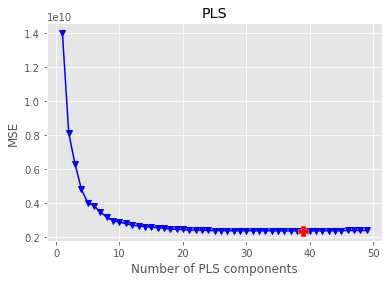

In [11]:
plot_metrics(mses, 'MSE', 'min')

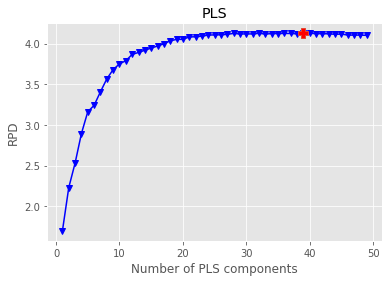

In [12]:
plot_metrics(rpds, 'RPD', 'max')

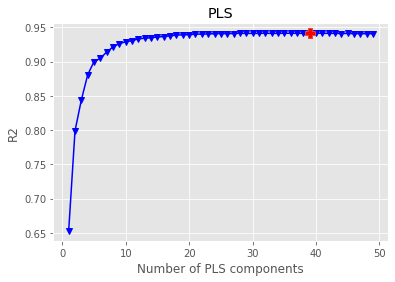

In [13]:
plot_metrics(r2s, 'R2', 'max')

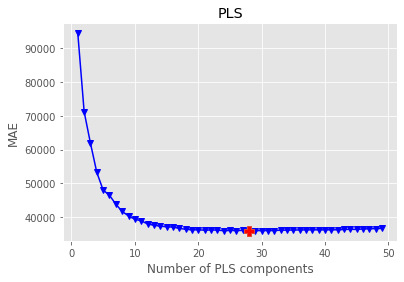

In [14]:
plot_metrics(maes, 'MAE', 'min')

But in order to aviod overfitting with the training set, we will try to use 3 values of components to see if smaller values will work better. 

In [15]:
pls1 = PLSRegression(n_components=20).fit(x_train, y_train)
x_train_1 = pls1.transform(x_train)
x_test_1 = pls1.transform(x_test)

In [16]:
pls2 = PLSRegression(n_components=30).fit(x_train, y_train)
x_train_2 = pls2.transform(x_train)
x_test_2 = pls2.transform(x_test)

In [17]:
pls3 = PLSRegression(n_components=39).fit(x_train, y_train)
x_train_3 = pls3.transform(x_train)
x_test_3 = pls3.transform(x_test)

#### Support Vector Machine

In [18]:
# creating a metrics matrix in order to visualize the different results
df_metricas=pd.DataFrame(columns=['train_R2', 'test_R2', 'train_MAXerror', 'test_MAXerror',
                                 'train_mae', 'test_mae', 'train_mse', 'test_mse', 
                                  'train_rmse', 'test_rmse'], 
                         index=['SVM_1',  # 1 means 20 components after dimension reduction
                                'SVM_2',  # 2 means 30 components after dimension reduction
                                'SVM_3']) # 3 means 39 components after dimension reduction

In [19]:
# Metrics for evaluating
def metrics(y_train, pred_train, y_test, pred_test, model):
    # Varianza explicada
    ve_train = explained_variance_score(y_train, pred_train)
    ve_test = explained_variance_score(y_test, pred_test)
    print('explained variance of training set:',(ve_train))
    print('explained variance of testing set:',(ve_test))
    df_metricas.loc[model, 'train_R2']=ve_train
    df_metricas.loc[model, 'test_R2']=ve_test
    # Maximum error
    me_train = max_error(pred_train, y_train)
    me_test = max_error(pred_test, y_test)
    print('maximum error of training set:',(me_train))
    print('maximum error of testing set:',(me_test))
    df_metricas.loc[model, 'train_MAXerror']=me_train
    df_metricas.loc[model, 'test_MAXerror']=me_test
    # mean absolute error: datos mal predichos, no al cuadrado, menor peso
    mae_train = mean_absolute_error(pred_train, y_train)
    mae_test = mean_absolute_error(pred_test, y_test)
    print('mae of training set:',(mae_train))
    print('mae of testing set:',(mae_test))
    df_metricas.loc[model, 'train_mae']=mae_train
    df_metricas.loc[model, 'test_mae']=mae_test
    # mean squared error: al cuadrado 
    # raiz de mse
    mse_train = mean_squared_error(pred_train, y_train)
    mse_test = mean_squared_error(pred_test, y_test)
    print('mse of training set:',(mse_train))
    print('mse of testing set:',(mse_test))
    df_metricas.loc[model, 'train_mse']=mse_train
    df_metricas.loc[model, 'test_mse']=mse_test
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    print('rmse of training set:',(rmse_train))
    print('rmse of testing set:',(rmse_test))
    df_metricas.loc[model, 'train_rmse']=rmse_train
    df_metricas.loc[model, 'test_rmse']=rmse_test

In [32]:
params_svm1 = {'C': loguniform(10e-5, 10e+5),
               'gamma': loguniform(10e-5, 10e+1),
               'kernel': ['rbf']}

svm1 = optimize_svm(x_train_1, y_train, params_svm1)
svm1

SVR(C=233007.13692358672, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=0.0001666016871705327, kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [33]:
svm1_pred_train = svm1.predict(x_train_1)
svm1_pred_test = svm1.predict(x_test_1)

metrics(y_train, svm1_pred_train, y_test, svm1_pred_test, 'SVM_1')

explained variance of training set: 0.9726371390558515
explained variance of testing set: 0.9586398888602016
maximum error of training set: 296944.1189330247
maximum error of testing set: 371452.91032253875
mae of training set: 24353.313888776436
mae of testing set: 31495.76223810685
mse of training set: 1101829991.5835176
mse of testing set: 1800790488.0114117
rmse of training set: 33193.824600119784
rmse of testing set: 42435.72183917002


In [34]:
params_svm2 = {'C': loguniform(10e-5, 10e+5),
               'gamma': loguniform(10e-5, 10e+1),
               'kernel': ['rbf']}

svm2 = optimize_svm(x_train_2, y_train, params_svm2)
svm2

SVR(C=220108.58881302745, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=0.0006992669762335396, kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [35]:
svm2_pred_train = svm2.predict(x_train_2)
svm2_pred_test = svm2.predict(x_test_2)

metrics(y_train, svm2_pred_train, y_test, svm2_pred_test, 'SVM_2')

explained variance of training set: 0.9915025454963666
explained variance of testing set: 0.9479538635702939
maximum error of training set: 201229.93585255183
maximum error of testing set: 380258.1993800573
mae of training set: 10708.161795139737
mae of testing set: 34383.52915315194
mse of training set: 342517242.11499524
mse of testing set: 2269969739.8542433
rmse of training set: 18507.221350461965
rmse of testing set: 47644.19943554769


In [36]:
params_svm3 = {'C': loguniform(10e-5, 10e+5),
               'gamma': loguniform(10e-5, 10e+1),
               'kernel': ['rbf']}

svm3 = optimize_svm(x_train_3, y_train, params_svm3)
svm3

SVR(C=539002.1234904168, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=0.0010122400450617694, kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [37]:
svm3_pred_train = svm3.predict(x_train_3)
svm3_pred_test = svm3.predict(x_test_3)

metrics(y_train, svm3_pred_train, y_test, svm3_pred_test, 'SVM_3') # best metric up to now

explained variance of training set: 0.998997882715469
explained variance of testing set: 0.9341886211703215
maximum error of training set: 152171.11526741408
maximum error of testing set: 445553.6992665534
mae of training set: 1798.9078625409556
mae of testing set: 37950.09946489518
mse of training set: 40368663.21202559
mse of testing set: 2865141961.534558
rmse of training set: 6353.633858826427
rmse of testing set: 53527.020854280294


In [38]:
df_metricas

,train_R2,test_R2,train_MAXerror,test_MAXerror,train_mae,test_mae,train_mse,test_mse,train_rmse,test_rmse
SVM_1,0.972637,0.95864,296944,371453,24353.3,31495.8,1.10183e+09,1.80079e+09,33193.8,42435.7
SVM_2,0.991503,0.947954,201230,380258,10708.2,34383.5,3.42517e+08,2.26997e+09,18507.2,47644.2
SVM_3,0.998998,0.934189,152171,445554,1798.91,37950.1,4.03687e+07,2.86514e+09,6353.63,53527


In [42]:
# Best model for Spanish electricity production
42435.7/np.mean(test['response'])

0.1205499001562852

In [43]:
# precision
1-42435.7/np.mean(test['response']) 

0.8794500998437148

#### Baseline model: Linear Regression

In [39]:
from sklearn import linear_model

lm = linear_model.LinearRegression()
lm.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [40]:
lm_pred_train = lm.predict(x_train)
lm_pred_test = lm.predict(x_test)

In [41]:
ve_train = explained_variance_score(y_train, lm_pred_train)
ve_test = explained_variance_score(y_test, lm_pred_test)
print('explained variance of training set:',(ve_train))
print('explained variance of testing set:',(ve_test))
# Maximum error
me_train = max_error(lm_pred_train, y_train)
me_test = max_error(lm_pred_test, y_test)
print('maximum error of training set:',(me_train))
print('maximum error of testing set:',(me_test))
# mean absolute error: datos mal predichos, no al cuadrado, menor peso
mae_train = mean_absolute_error(lm_pred_train, y_train)
mae_test = mean_absolute_error(lm_pred_test, y_test)
print('mae of training set:',(mae_train))
print('mae of testing set:',(mae_test))
# mean squared error: al cuadrado 
# raiz de mse
mse_train = mean_squared_error(lm_pred_train, y_train)
mse_test = mean_squared_error(lm_pred_test, y_test)
print('mse of training set:',(mse_train))
print('mse of testing set:',(mse_test))
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
print('rmse of training set:',(rmse_train))
print('rmse of testing set:',(rmse_test))

explained variance of training set: 0.9803943000970675
explained variance of testing set: 0.9250961994990482
maximum error of training set: 184837.2621007465
maximum error of testing set: 396570.13765289314
mae of training set: 21766.850759637444
mae of testing set: 44624.01357955864
mse of training set: 789469611.1508766
mse of testing set: 3325849568.3987036
rmse of training set: 28097.501866729657
rmse of testing set: 57670.17919513259


#### Fraction of variance in X explained by each latent vector after PLS regression

In [44]:
# X is a numpy ndarray with samples in rows and predictor variables in columns
# y is one-dimensional ndarray containing the response variable

total_variance_in_x = np.var(x_train, axis = 0)

pls1 = PLSRegression(n_components = 20)
pls1.fit(x_train, y_train) 

# variance in transformed X data for each latent vector:
variance_in_x = np.var(pls1.x_scores_, axis = 0) 

# normalize variance by total variance:
fractions_of_explained_variance = variance_in_x / sum(total_variance_in_x)

In [45]:
fractions_of_explained_variance

array([3.90408030e-06, 1.52009838e-06, 2.15529123e-06, 6.17924609e-07,
       8.59330299e-07, 9.57639519e-07, 6.49827746e-07, 1.69845763e-07,
       1.72031874e-07, 1.91742500e-07, 1.72444903e-07, 9.47594885e-08,
       1.85592633e-07, 1.16103585e-07, 8.21928159e-08, 1.15159125e-07,
       5.18649326e-08, 8.72193434e-08, 7.16043771e-08, 5.47698783e-08])

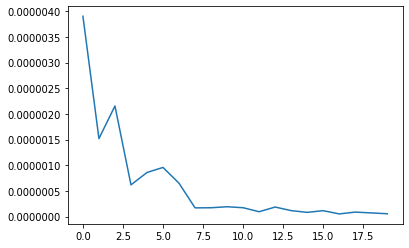

In [46]:
# explained variance per each component 
plt.plot(fractions_of_explained_variance)

In [47]:
cumulative_ex_variance = np.cumsum(fractions_of_explained_variance)
cumulative_ex_variance

array([3.90408030e-06, 5.42417868e-06, 7.57946991e-06, 8.19739452e-06,
       9.05672482e-06, 1.00143643e-05, 1.06641921e-05, 1.08340378e-05,
       1.10060697e-05, 1.11978122e-05, 1.13702571e-05, 1.14650166e-05,
       1.16506092e-05, 1.17667128e-05, 1.18489056e-05, 1.19640648e-05,
       1.20159297e-05, 1.21031490e-05, 1.21747534e-05, 1.22295233e-05])

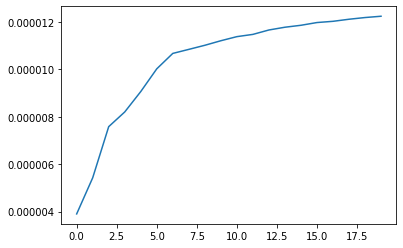

In [49]:
# cumulative explained variance per component 
plt.plot(cumulative_ex_variance)

### baseline model

In [7]:
pls1 = PLSRegression(n_components=20).fit(x_train, y_train)

pred_train_pls = pls1.predict(x_train)
pred_test_pls = pls1.predict(x_test)

In [8]:
ve_train = explained_variance_score(y_train, pred_train_pls)
ve_test = explained_variance_score(y_test, pred_test_pls)
print('explained variance of training set:',(ve_train))
print('explained variance of testing set:',(ve_test))
# Maximum error
me_train = max_error(pred_train_pls, y_train)
me_test = max_error(pred_test_pls, y_test)
print('maximum error of training set:',(me_train))
print('maximum error of testing set:',(me_test))
# mean absolute error: datos mal predichos, no al cuadrado, menor peso
mae_train = mean_absolute_error(pred_train_pls, y_train)
mae_test = mean_absolute_error(pred_test_pls, y_test)
print('mae of training set:',(mae_train))
print('mae of testing set:',(mae_test))
# mean squared error: al cuadrado 
# raiz de mse
mse_train = mean_squared_error(pred_train_pls, y_train)
mse_test = mean_squared_error(pred_test_pls, y_test)
print('mse of training set:',(mse_train))
print('mse of testing set:',(mse_test))
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
print('rmse of training set:',(rmse_train))
print('rmse of testing set:',(rmse_test))

explained variance of training set: 0.9514657584915945
explained variance of testing set: 0.9459657418929653
maximum error of training set: 476889.42592628184
maximum error of testing set: 393823.9071132399
mae of training set: 32704.334611506853
mae of testing set: 36731.367979465234
mse of training set: 1954345366.9518096
mse of testing set: 2369177961.20581
rmse of training set: 44207.97854405706
rmse of testing set: 48674.2022143744
